In [7]:
cd /Users/cl1704/PycharmProjects/clustering_in_rnns

/Users/cl1704/PycharmProjects/clustering_in_rnns


In [8]:
from Experiment_2.TwoAFCTask import generate_trials
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from Experiment_2.net import *
import os
import statsmodels.api as sm
import scipy.optimize as opt
import math
#from psychometrics import *

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
plt.rcParams["axes.grid"] = False
from sklearn.manifold import TSNE
matplotlib.rcParams['axes.linewidth'] = .5

In [9]:
def compute_var(variance,n):
    return np.sum(variance[n:])

def compute_p(k, null_k):
    return np.sum(null_k<k)/len(null_k)

In [10]:
df_list = []
for filename in os.listdir('Experiment_2/Results_2'):
    f = os.path.join('Experiment_2/Results_2', filename)
    if os.path.isfile(f):
        df_list.append(pd.read_pickle(f))
original_df = pd.concat(df_list,ignore_index=True) 
original_df = original_df[original_df.mse_z<.035]
original_df = original_df[original_df.lambda_std==0.1]
original_df = original_df[original_df.sigma_rec==0.]

0.3483413597617315
0.31390165670158066
0.3566994212962963
0.31583640046296296
0.3506207175925926
0.3162768884579732
0.3156596278171727
0.355120527213024
0.34944989576966384


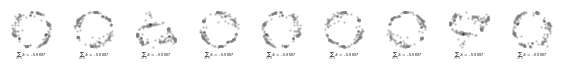

In [13]:
# Trial data for simulations
u, z, mask, conditions  = generate_trials(
                                    n_trials=100)



fig = plt.figure(figsize=(7,.5))
gs = gridspec.GridSpec(1,9,wspace = .5)

# Load data for row
df =original_df.copy()

k = 3
df  = df[df.dim==k]
#df = df[df.k>=dim]
df['k_inertia'] = df.inertia.apply(lambda x: x[k-1])
df['var'] = df.variance.apply(lambda x: compute_var(x,k))
df['var'] = np.log(df['var'])
df = df.sort_values('var',ascending=True)
#bins = np.linspace(-3,-.75,9)

# 
# df['bin'] = pd.cut(df['var'],bins=bins)
# df['mean'] = df.bin.apply(lambda x: np.mean([x.left,x.right]))
# df['mean'] = df['mean'].astype(float).round(3)
# bin_means = np.sort(df['mean'].unique())
# For rates:
idx = [13282,13487,13324,10156,10318,13868,6643,5399,2306]

#bins = [0,.025,.05,.1,.2,.3,.4,.5,.6]
for col in range(9):
    # Create axis
    ax=fig.add_subplot(gs[0,col])
    # Load model data for column
    
    #model_id = df[df.index==idx[col]].model_id.values[0]
    model_id = "z1Sal2SL"
    #model_id  = df[ (df['mean'] ==bin_means[col] )].sort_values('var')['model_id'].values[1]
    model_data = df[df.model_id==model_id]
    #k = model_data['k'].item()
    k = 3
    # Simulate model
    net = Net(n=200,input_size = 2,dale=False)
    net.recurrent_layer.weight.data = torch.tensor(model_data['w_rec'].item())
    net.recurrent_layer.bias.data = torch.tensor(model_data['bias'].item())
    net.input_layer.weight.data = torch.tensor(model_data['w_in'].item())
    net.output_layer.weight.data = torch.tensor(model_data['w_out'].item())


    x = net(u).detach().cpu().numpy()

    
        
    rows = []
    for k in range(u.shape[0]):
        rows.append({'trial': k,
                     'motion': conditions[k]['motion_coh'],
                     'response': x[k, :, :]})
    new_df = pd.DataFrame(rows)
    new_df = new_df.groupby(['motion']).response.apply(lambda r: np.mean(np.stack(r), axis=0)).reset_index()
    
    #df = df.groupby('motion').response.apply(lambda r: np.mean(np.stack(r), axis=0)).reset_index()
    responses = np.stack(new_df.response.values)
    responses = responses.reshape(-1, responses.shape[2]).T
    
    #responses = responses[np.mean(responses, axis=1) >.15, :]
    
    # z_score
    responses = (responses - np.mean(responses, axis=1, keepdims=True)) / np.std(responses, axis=1, keepdims=True)
    responses = responses[~np.isnan(responses).any(axis=1)]
    
    
    
    #responses = .001 * (2*np.random.rand(responses.shape[0],responses.shape[1])-1)
    total_variance = np.sum((responses.T - np.mean(responses.T, axis=0, keepdims=True)) ** 2)

    clustering = KMeans(n_clusters=3,n_init='auto').fit(responses)
    labels  = clustering.labels_
    print(clustering.inertia_/total_variance)

    #responses  = responses + .5*(2*np.random.rand(responses.shape[0],responses.shape[1])-1)
    
    X = responses
    y = labels
    lda = LinearDiscriminantAnalysis(solver='eigen',  shrinkage=9e-1)
    
    # parameters = {'tol':10**np.linspace(-2,-.5,25)}
    # from sklearn.model_selection import GridSearchCV
    # clf = GridSearchCV(lda, parameters,refit=True,error_score = np.nan,cv=5)
    # clf.fit(X, y)
    # lda = clf.best_estimator_
    x_proj = lda.fit_transform(X,y)
    

        
    centers_proj = lda.transform(clustering.cluster_centers_)
    #scale = np.sum(PCA().fit(centers_proj).explained_variance_[:2])/100
   
    
    
    #x_proj = x_proj + 1*(2*np.random.rand(x_proj.shape[0],x_proj.shape[1])-1)
    network_pal = sns.husl_palette(pd.Series(np.sort(labels)).unique().size,s=1)
    
    lut = dict(zip(pd.Series(np.sort(labels)).unique(),network_pal))
    row_colors = pd.Series(np.sort(labels)).map(lut)
    
    sns.scatterplot(x=x_proj[np.argsort(labels), 0], y=x_proj[np.argsort(labels), 1], color='gray',s=2,alpha=.5,ax=ax,edgecolor=None)
    sns.scatterplot(x=centers_proj[:, 0], y=centers_proj[:, 1], color='k',s=3,alpha=.5,ax=ax,edgecolor=None)

    # Make axis pretty
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_xlabel("PC 1",fontsize=6)
    ax.set_ylabel("PC 2",fontsize=6)
    #ax.set_title(r'$\sum_{i\geq 2}\lambda_i = $'+str(np.round(variance,4)),fontsize=8)
    ax.xaxis.set_tick_params(labelsize=6,bottom=False)
    ax.yaxis.set_tick_params(labelsize=6,left=False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.text(.5,-.2,r'$\sum_{i>3}\lambda_i = $'+' '+str(np.round(model_data['var'].item(),4) ), horizontalalignment='center',
 verticalalignment='center', transform=ax.transAxes,fontsize = 3)
    
fig.savefig('Figures/SIFig_2afcclustering.jpg',
    format='jpeg',
    dpi=450,
            bbox_inches='tight')


In [6]:
df.model_id.values[0]

'HkpwQGCq'